In [1]:
import numpy as np 
import cv2 
from matplotlib import pyplot as plt 
import PIL
from time import time 

In [2]:
def SobelEdge(img, display = 1): 
    gx = np.array([[-1.0, 0.0, 1.0], 
                   [-2.0, 0.0, 2.0], 
                   [-1.0, 0.0, 1.0]])
    gy = np.array([[-1.0, -2.0, -1.0], 
                   [0.0, 0.0, 0.0], 
                   [1.0, 2.0, 1.0]])
    [row, col] = np.shape(img) 
    sobel_filtered_image = np.zeros(np.shape(img))
    angle_matrix = np.zeros(np.shape(img))
    Gx = np.zeros(np.shape(img))
    Gy = np.zeros(np.shape(img))
    
    for i in range(row - 2): 
        for j in range(col - 2):
            temp = img[i:i + 3, j:j + 3]
            Gx[i+1, j+1] = np.sum(np.multiply(gx, temp))  
            Gy[i+1, j+1] = np.sum(np.multiply(gy, temp))  
            sobel_filtered_image[i + 1, j + 1] = np.sqrt(Gx[i+1,j+1] ** 2 + Gy[i+1,j+1] ** 2)
            angle = np.abs(np.arctan(Gy[i+1,j+1]/ (Gx[i+1,j+1]+0.0001))/np.pi * 180)
            if angle>=0 and angle<45/2:
                angle = 0
            elif angle>=45/2 and angle<45:
                angle = 45
            elif angle>=45 and angle<45+45/2:
                angle = 45
            elif angle>=45+45/2 and angle<90:
                angle = 90
            angle_matrix[i + 1, j + 1] = angle                
            
    if display == 1:
        fig, ax = plt.subplots(1, 2, figsize=(14, 14))
        ax[0].imshow(Gx, cmap = plt.get_cmap('gray'))
        ax[0].set_title("X-directed gradient image")
        ax[1].imshow(Gy, cmap = plt.get_cmap('gray'))
        ax[1].set_title("Y-directed gradient image")
        plt.show()
    return sobel_filtered_image, angle_matrix

In [17]:
def nonMaximumSuppression(grad, dir, img):

    non_max = np.zeros(img.shape)
    h, w = grad.shape 

    for i in range(1, h - 1):
        for j in range(1, w - 1):
            
            if dir[i, j] == 0:
                l = grad[i, j-1]
                c = grad[i, j]
                r = grad[i, j+1] 

            elif dir[i, j] == 45:
                l = grad[i-1, j-1]
                c = grad[i, j]
                r = grad[i+1, j+1]
 
            elif dir[i, j] == 90:
                l = grad[i-1, j]
                c = grad[i, j]
                r = grad[i+1, j]

            else:
                continue 

            max_I = max(l, c, r)
            if(c == max_I):
                non_max[i, j] = c
            else:
                non_max[i, j] = 0
    return non_max

In [18]:
def doubleThreshold(non_max):

    t1 = 0.3 * 255
    t2 = 0.8 * 255 

    h, w = non_max.shape
    dt = np.zeros((h, w))

    for i in range(h):
        for j in range(w):

            if non_max[i, j] < t1:
                dt[i, j] = 0
            elif non_max[i, j] > t2:
                dt[i, j] = 255 
            else:
                dt[i, j] = non_max[i, j]

    return dt 

In [23]:
def hysterisisEdge(dt):

    hyst_edge = dt 
    h, w = hyst_edge.shape 

    for i in range(h):
        for j in range(w):
            
            if hyst_edge[i, j] !=0 and hyst_edge[i, j] != 255:
                n = [
                    hyst_edge[i+1, j-1], 
                    hyst_edge[i+1, j], 
                    hyst_edge[i+1, j+1], 
                    hyst_edge[i, j-1], 
                    hyst_edge[i, j+1], 
                    hyst_edge[i-1, j-1], 
                    hyst_edge[i-1, j], 
                    hyst_edge[i-1, j+1]
                ]

                if max(n) == 255:
                    hyst_edge[i, j] = 255
                else:
                    hyst_edge[i, j] = 0
    return hyst_edge 

In [24]:
def Canny(img):

    blurred = cv2.GaussianBlur(img, (5, 5), 1)

    grad, dir = SobelEdge(img)
    non_max_supp = nonMaximumSuppression(grad, dir, img)
    dt = doubleThreshold(non_max_supp)
    cannyEdge = hysterisisEdge(dt)

    params = {
        "GaussianBlurred": blurred,
        "Gradient": grad,
        "Direction": dir,
        "NonMaxSuppression": non_max_supp,
        "DoubleThreshold": dt, 
        "CannyEdge": cannyEdge
    }

    return params 

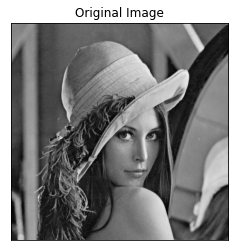

In [25]:
img = cv2.imread("lena.tif", 0)

plt.imshow(img, cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title("Original Image")
plt.show()

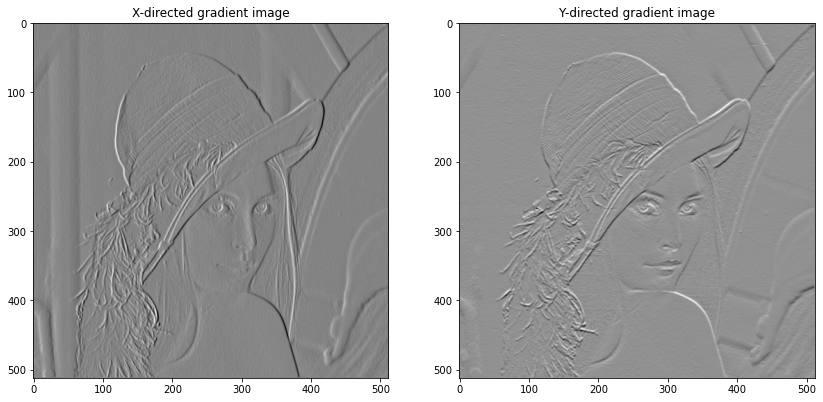

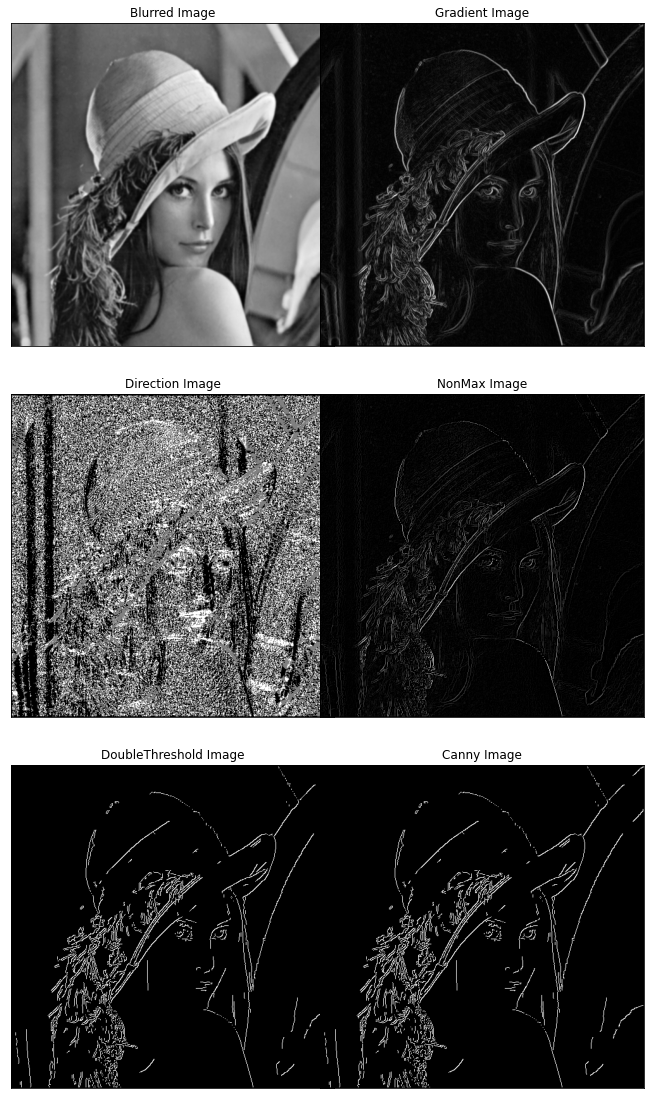

In [30]:
canny_params = Canny(img) 

fig = plt.figure(figsize = (10, 10))

ax1 = fig.add_subplot(321)
ax1.imshow(canny_params["GaussianBlurred"], cmap = 'gray')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("Blurred Image")

ax2 = fig.add_subplot(322)
ax2.imshow(canny_params["Gradient"], cmap = 'gray')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title("Gradient Image")

ax3 = fig.add_subplot(323)
ax3.imshow(canny_params["Direction"], cmap = 'gray')
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title("Direction Image")

ax2 = fig.add_subplot(324)
ax2.imshow(canny_params["NonMaxSuppression"], cmap = 'gray')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title("NonMax Image")

ax1 = fig.add_subplot(325)
ax1.imshow(canny_params["DoubleThreshold"], cmap = 'gray')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("DoubleThreshold Image")

ax2 = fig.add_subplot(326)
ax2.imshow(canny_params["CannyEdge"], cmap = 'gray')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title("Canny Image")

fig.tight_layout()
fig.subplots_adjust(top = 1.5)

